In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP

In [2]:
# Function to replace n/a in the data by the average of the data before and after the n/a
def fix_na(col):
    prev_is_na = False
    before = 0.0
    na_idxs = []
    for i in range(len(col)):
        val = str(col[i])
        if not prev_is_na and 'n/a' in val:
            prev_is_na = True
            before = col[i - 1]
            na_idxs.append(i)
        elif prev_is_na and 'n/a' in val:
            na_idxs.append(i)
        elif prev_is_na and 'n/a' not in val:
            col[i] = float(col[i])
            prev_is_na = False
            ave = (before + col[i]) / 2
            for j in na_idxs:
                col[j] = ave
            na_idxs = []
            before = 0.0
        else:
            col[i] = float(val)
    return col

# Read the data from the Central Energy Plant and clean up the data
plant_data = pd.read_csv('Plant Steam Data.csv', nrows=9000)
plant_data.columns = ['date', 'time', 'pressure', 'steam flow', 'air temp', 'facility pressure']
all_dates = plant_data['date'].values
all_times = plant_data['time'].values
all_pressures = fix_na(plant_data['pressure'].values)
all_steam_flows = fix_na(plant_data['steam flow'].values)
all_air_temps = fix_na(plant_data['air temp'].values)
all_facility_pressures = fix_na(plant_data['facility pressure'].values)
months, days, years = [], [], []
for date in all_dates:
    #print(str(date))
    month, day, year = date.split('/')
    months.append(int(month))
    days.append(int(day))
    years.append(int(year))

hours = []
for time in all_times:
    number, period = time.split(' ')
    hour, minute, second = number.split(':')
    if period == 'PM':
        if hour != '12':
            hour = int(hour) + 12
    else:
        if hour == '12':
            hour = 0
    hours.append(int(hour))

# Create a new DataFrame with the cleaned up data
cleaned_plant_data = pd.DataFrame({
    'Month': months,
    'Day': days,
    'Year': years,
    'Hour': hours,
    'Pressure': all_pressures,
    'Steam Flow': all_steam_flows,
    'Air Temp': all_air_temps,
    'Facility Pressure': all_facility_pressures
})

# Read the steam usage data and clean up the data
steam_usage = pd.read_csv('Steam Usage Year.csv')
steam_usage = steam_usage.drop(columns=['Unnamed: 2', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19'])
steam_usage = steam_usage.rename(columns={'Unnamed: 0': 'Building', 'Unnamed: 1': 'MeterNo'})
steam_usage = steam_usage.drop([0]).reset_index(drop=True)
data_months = ['Sep-24', 'Aug-24', 'Jul-24', 'Jun-24', 'May-24', 'Apr-24', 'Mar-24', 'Feb-24', 'Jan-24', 'Dec-23', 'Nov-23', 'Oct-23']
for month in data_months:
    data = steam_usage[month]
    for i in range(len(data)):
        data[i] = round(float(data[i]), 2)


In [3]:
# Show the first few rows of the plant data, steam flow is in lb/hr
cleaned_plant_data.head()

,Month,Day,Year,Hour,Pressure,Steam Flow,Air Temp,Facility Pressure
0,10,16,2024,7,88.45,23397.28,52.46,69.75
1,10,16,2024,6,90.40,18584.67,53.2,72.36
2,10,16,2024,5,90.74,17030.57,54.41,72.54
3,10,16,2024,4,90.78,15487.72,55.27,72.61
4,10,16,2024,3,90.79,15050.83,56.0,72.9


In [4]:
# Show the first few rows of the steam usage data, usage data is in lbs/month
steam_usage.head()

,Building,MeterNo,Sep-24,Aug-24,Jul-24,Jun-24,May-24,Apr-24,Mar-24,Feb-24,Jan-24,Dec-23,Nov-23,Oct-23
0,Spectrum,7001,188349.63,175837.97,188216.35,201819.24,254298.24,420523.39,501457.67,670398.4,270591.72,262836.49,374283.56,336207.13
1,HPER,7002,496121.82,428632.85,301262.95,376176.62,551236.28,1241250.35,1754496.48,2184241.26,2533989.86,2360073.89,1954505.15,1633268.0
2,Family Life,7003,0.0,0.0,0.0,0.0,107670.0,196210.0,265330.0,254850.0,343760.0,323570.0,301520.0,194380.0
3,Maeser,7004,245638.0,217663.0,206800.0,222726.0,291209.0,381654.0,550546.0,623689.0,777253.0,730016.0,556323.0,361156.0
4,TSC,7006,198658.72,162076.85,187992.48,246323.48,407983.68,544894.87,673223.07,852632.56,938545.79,873548.39,605475.78,327486.9


In [5]:
# Grab the time data for the most recent full day
start_index = 8
end_index = start_index + 24
times = cleaned_plant_data['Hour'][start_index:end_index].values

# Grab the steam flow data for the most recent full day
steam_flows = cleaned_plant_data['Steam Flow'][start_index:end_index].values
m_dot_steam = []
for i in range(len(steam_flows)):
    m_dot_steam.append(round(steam_flows[i] / 1000, 3))

# Grab the outside air temperature data for the most recent full day
air_temps = cleaned_plant_data['Air Temp'][start_index:end_index].values

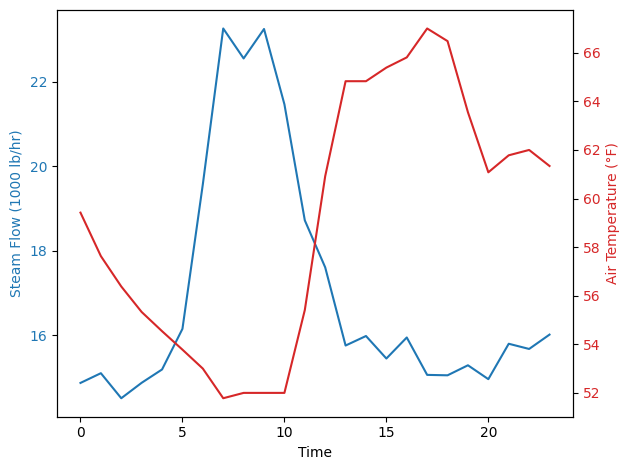

In [6]:
fig, ax1 = plt.subplots()

# Plot steam flow data
ax1.set_xlabel('Time')
ax1.set_ylabel('Steam Flow (1000 lb/hr)', color='tab:blue')
ax1.plot(times, m_dot_steam, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot air temperature data
ax2 = ax1.twinx()
ax2.set_ylabel('Air Temperature (°F)', color='tab:red')
ax2.plot(times, air_temps, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

In [7]:
# Sum all values in the 'Mar-24' column of the steam usage data
total_mar_24 = round(steam_usage['Mar-24'].sum(), 2)
print("Total Steam Used in March:", round(total_mar_24/2000,2), "tons")

# Calculate the total steam produced by the plant in March
month_vals = cleaned_plant_data['Month'].values
steam_flow_vals = cleaned_plant_data['Steam Flow'].values
total_steam = 0
for i in range(len(month_vals)):
    if month_vals[i] == 3:
        total_steam += steam_flow_vals[i]
total_steam = round(total_steam, 2)
print("Total Steam Produced in March:", round(total_steam/2000,2), "tons")

# Calculate the difference between the total steam used and the total steam produced
diff = total_steam - total_mar_24
print("Difference in Steam Used and Steam Produced:", round(diff/2000,2), "tons")
print("Percent Difference:", round((diff / total_steam) * 100, 2), "%")

Total Steam Used in March: 11763.59 tons
Total Steam Produced in March: 13048.17 tons
Difference in Steam Used and Steam Produced: 1284.57 tons
Percent Difference: 9.84 %


In [8]:
# Placeholder values for enthalpy in and out
enthalpy_ss_90 = 2764.04
enthalpy_sw_atm = 418.99

# Calculate the heat transferred to a building
def heat_transferred(m_dot, h1, h2):
    return round(m_dot * (h2 - h1), 2)

Total Energy Transferred in September
Spectrum: 441689.3 MJ
HPER: 1163430.47 MJ
Family Life: 0.0 MJ
Maeser: 576033.39 MJ
TSC: 1793500.67 MJ
FeildHouse: 375153.9 MJ
Ind Science: 184606.67 MJ
ECC: 122523.96 MJ
INN: 412712.29 MJ
Facilities: 87154.21 MJ
NFS: 464474.67 MJ
Business: 715606.08 MJ
BNR: 1193367.76 MJ
NR: 83070.07 MJ
HSRC: 104116.05 MJ
Eng New: 292904.58 MJ
Eng lab: 906911.81 MJ
Merrill: 137922.5 MJ
FA Center: 382931.35 MJ
FA Museum: 398264.53 MJ
LLC: 740498.08 MJ
FA Visual: 455546.83 MJ
Richards: 194650.9 MJ
SER: 453182.32 MJ
Junction: 486117.14 MJ
Bullen: 137824.8 MJ
Old Main: 422287.53 MJ
Forage Range: 622546.78 MJ
Geology: 406263.66 MJ
Ray B West: 166237.85 MJ
Biotech: 519056.06 MJ
Education: 209345.97 MJ
Sci Tech Lib: 253841.51 MJ
Widtsoe: 699160.24 MJ
Edith Bowen: 265682.44 MJ
Forestry Science: 73494.83 MJ
Uni Reserve: 69500.25 MJ
Alumni: 25306.0 MJ
Quinney Lawson: 106578.25 MJ
Perf Hall: 93446.51 MJ
MC Lib: 453162.79 MJ
Eng Sant: 186424.02 MJ
Vet Science: 551056.26 MJ
Lil

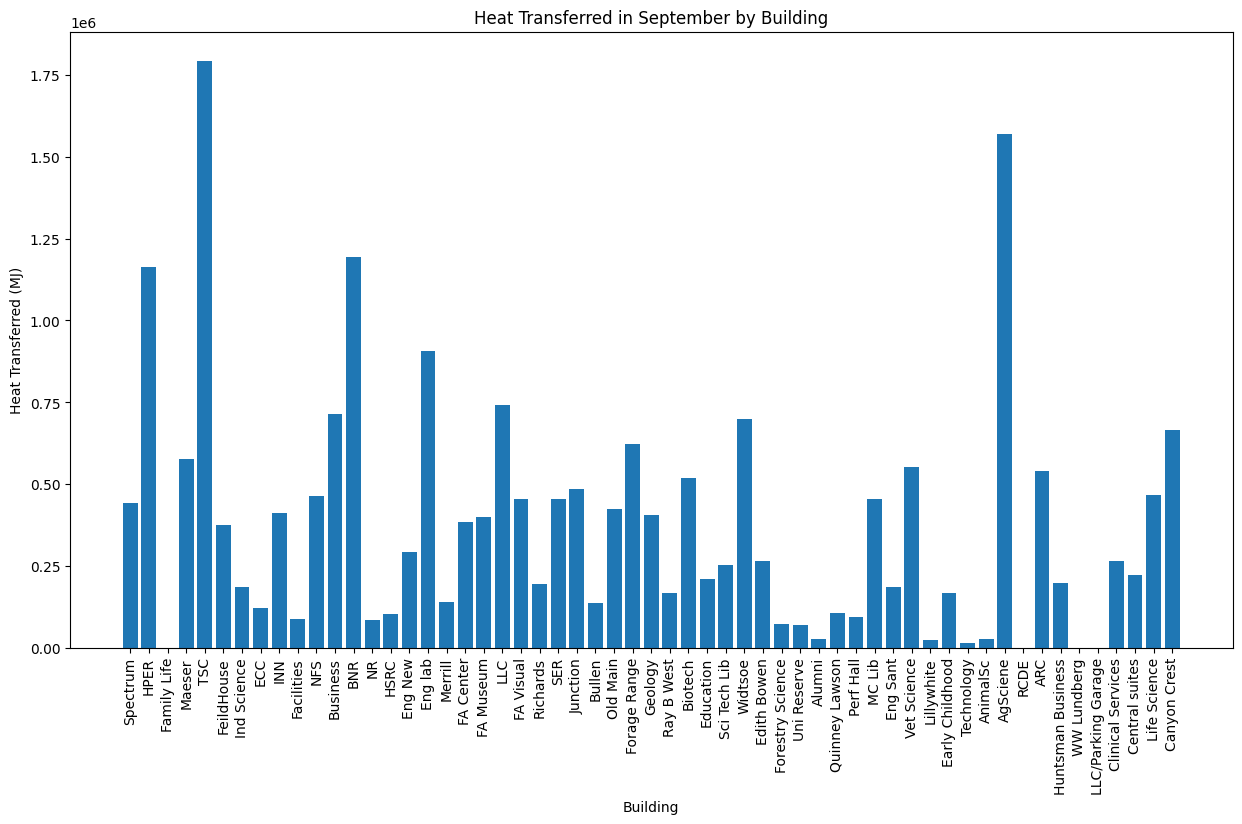

In [9]:
# Plot heat transferred to each building in September
september_steam = steam_usage['Sep-24'].values
buildings = steam_usage['Building'].values
september_steam = [round(float(value), 2) for value in september_steam]
september_heat = []
for i in range(len(september_steam)):
    september_heat.append(heat_transferred(september_steam[i], enthalpy_sw_atm, enthalpy_ss_90))

# Aggregate the heat transferred to the TSC across the two valves
tsc_indexes = []
tsc_total_steam = 0
tsc_total_heat = 0
for i in range(len(buildings)):
    if buildings[i] == 'TSC':
        tsc_indexes.append(i)
        tsc_total_steam += september_steam[i]
        tsc_total_heat += september_heat[i]

# Print the results for all buildings
print("Total Energy Transferred in September")
tsc_printed = False
cleaned_buildings = []
cleaned_heat = []
for i in range(len(buildings)):
    if i not in tsc_indexes:
        print(buildings[i] + ': ' + str(round(september_heat[i]/1000, 2)) + ' MJ')
        cleaned_buildings.append(buildings[i])
        cleaned_heat.append(september_heat[i])
    else:
        if not tsc_printed:
            print('TSC: ' + str(round(tsc_total_heat/1000, 2)) + ' MJ')
            cleaned_buildings.append('TSC')
            cleaned_heat.append(tsc_total_heat)
            tsc_printed = True

plt.figure(figsize=(15, 8))
plt.bar(cleaned_buildings, [heat / 1000 for heat in cleaned_heat])
plt.xlabel('Building')
plt.ylabel('Heat Transferred (MJ)')
plt.title('Heat Transferred in September by Building')
plt.xticks(rotation=90)
plt.show()

In [10]:
# Get steam usage ratios
steam_usage_ratios = []
months = ['Sep-24', 'Aug-24', 'Jul-24', 'Jun-24', 'May-24', 'Apr-24', 'Mar-24', 'Feb-24', 'Jan-24', 'Dec-23', 'Nov-23', 'Oct-23']
month_nums = [9, 8, 7, 6, 5, 4, 3, 2, 1, 12, 11, 10]
for month in months:
    monthly_ratio = []
    steam_data = steam_usage[month].values
    total_steam = sum(steam_data)
    for valve in steam_data:
        monthly_ratio.append(valve / total_steam)
    steam_usage_ratios.append(monthly_ratio)

for ratio in steam_usage_ratios:
    print(ratio)

transposed_ratios = np.transpose(steam_usage_ratios)
df_ratios = pd.DataFrame(transposed_ratios, columns=month_nums, index=buildings)
df_ratios.head()

[0.02046257384415287, 0.05389938582542221, 0.0, 0.026686464496532444, 0.02158256816211897, 0.06150669802577026, 0.017380123037597017, 0.008552454649225091, 0.0056762878513626665, 0.019120127499326872, 0.004037678439725277, 0.021518174211523442, 0.03315258534878095, 0.0552863197509429, 0.0038484685187555544, 0.004823486275491727, 0.013569677934229724, 0.04201539380889017, 0.006389670961752876, 0.017740436698192405, 0.018450791971824792, 0.03430578157530675, 0.021104565409201533, 0.009017783292484552, 0.02099502225157994, 0.022520826003341068, 0.006385144959624031, 0.019563728942256334, 0.02884133582838671, 0.018821375507149893, 0.007701464126054292, 0.02404681987761121, 0.009698576145586925, 0.011759964782966672, 0.032390682974090625, 0.012308531233500694, 0.003404867075826095, 0.003219806171210204, 0.0011723757852350237, 0.004937555435242169, 0.004329188393930371, 0.020994117268437036, 0.008636648501116402, 0.025529324585962552, 0.0011096636040335063, 0.0077578674991995895, 0.000661517

,9,8,7,6,5,4,3,2,1,12,11,10
Spectrum,0.020463,0.021885,0.026038,0.025033,0.024279,0.024873,0.021314,0.025212,0.008587,0.008727,0.015853,0.019913
HPER,0.053899,0.053348,0.041677,0.046660,0.052630,0.073416,0.074573,0.082145,0.080417,0.078364,0.082782,0.096736
Family Life,0.000000,0.000000,0.000000,0.000000,0.010280,0.011605,0.011278,0.009584,0.010909,0.010744,0.012771,0.011513
Maeser,0.026686,0.027091,0.028609,0.027626,0.027803,0.022574,0.023400,0.023456,0.024666,0.024239,0.023563,0.021391
TSC,0.021583,0.020172,0.026007,0.030553,0.038953,0.032229,0.028615,0.032066,0.029785,0.029005,0.025645,0.019397


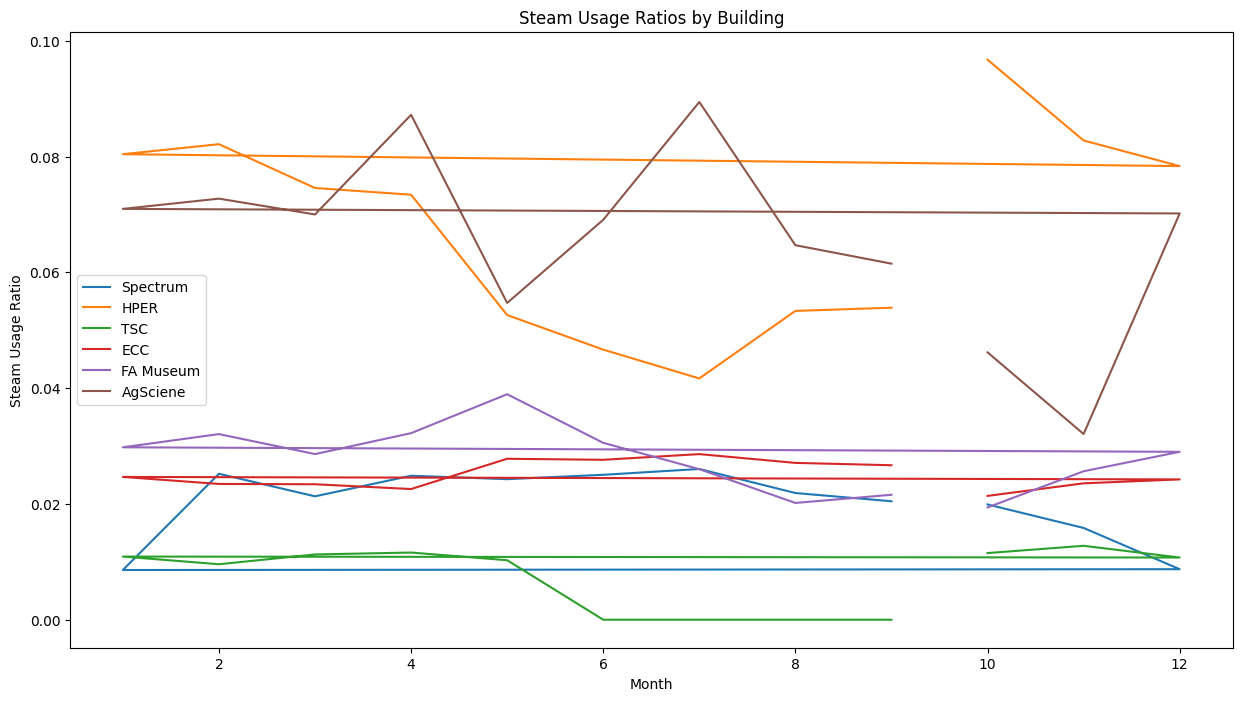

In [11]:
# Plot the steam usage ratios for each building
plot_indexes = [0, 1, 4, 8, 20, 48]
plots = []
plot_months = []
for index in plot_indexes:
    plots.append([])
for i in range(len(month_nums)):
    for j in range(len(plot_indexes)):
        plots[j].append(transposed_ratios[j][i])
for i in range(len(plot_indexes)):
    plot_months.append(buildings[plot_indexes[i]])
plt.figure(figsize=(15, 8))
for r in plots:
    plt.plot(month_nums, r)
plt.xlabel('Month')
plt.ylabel('Steam Usage Ratio')
plt.title('Steam Usage Ratios by Building')
plt.legend(plot_months)
plt.show()

In [13]:
# get building distances and calculate pressure drops
distances = []
pressure_drops = []
for building in buildings:
    # calculate a random distance for now
    dist = np.random.randint(1, 100) / 100.0
    distances.append(dist)
    pressure_drops.append(dist * 18.2)

In [14]:
# Functions for entropy calculations
def specific_entropy(P, Q, fluid='Water'):
    return CP.PropsSI('S', 'P', P, 'Q', Q, fluid)

def specific_enthalpy(P, Q, fluid='Water'):
    return CP.PropsSI('H', 'P', P, 'Q', Q, fluid)

def psi_to_pa(psi):
    return psi * 6894.76 + 85500

def get_building_data(index, p_drop):
    month, total_flow, plant_pressure, air_temp = cleaned_plant_data['Month'][index], cleaned_plant_data['Steam Flow'][index], cleaned_plant_data['Pressure'][index], cleaned_plant_data['Air Temp'][index]
    building_pressure = []
    building_steam = []
    month_ratio = df_ratios[month].values
    for i in range(len(p_drop)):
        building_pressure.append(psi_to_pa(plant_pressure - p_drop[i]))
        building_steam.append(total_flow * month_ratio[i])
    return total_flow, air_temp, building_pressure, building_steam

In [15]:
test_entr = specific_entropy(101325, 1.0)
print(test_entr)

test_enth = specific_enthalpy(101325, 1.0)
print(test_enth)


7354.427280271609
2675529.3255007486


In [ ]:
# Calculate the amount of heat lost at a specific time
def heat_and_enthalpy(plant_data_index):
